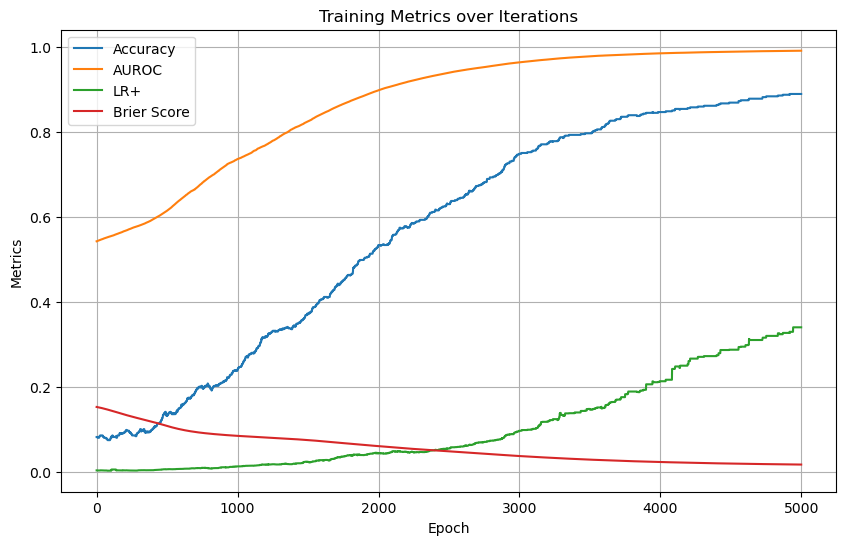

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.95      0.84      0.89        50
           2       0.88      0.94      0.91        47
           3       0.87      0.89      0.88        54
           4       0.89      0.93      0.91        60
           5       0.93      0.76      0.83        66
           6       0.91      0.98      0.95        53
           7       0.93      0.91      0.92        55
           8       0.82      0.86      0.84        43
           9       0.77      0.85      0.81        59

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540

Brier Score: 0.016600777287962314


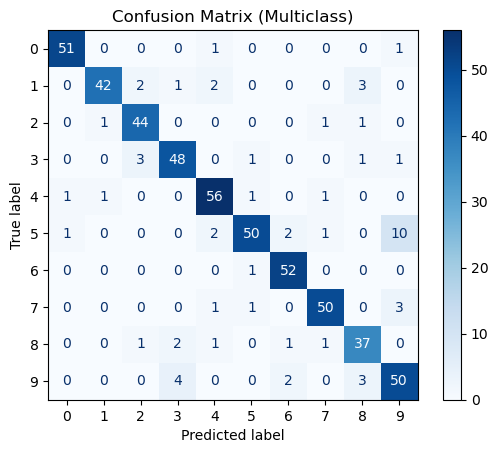

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss, roc_auc_score
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import numpy as np
import warnings


warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1, random_state=2, learning_rate_init=0.00001, warm_start=True)
accuracy_list = []
auc_list = []
lr_plus_list = []
brier_score_list = []
n_epochs = 5000
y_prob = None
y_pred = None

for epoch in range(n_epochs):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracy_list.append(accuracy)
    
    # Compute AUROC (one-vs-rest for multiclass)
    try:
        auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    except ValueError:
        auc = np.nan  # Handle cases where AUROC is not defined
    auc_list.append(auc)
    
    # Compute LR+ (Positive Likelihood Ratio) for each class
    cm = confusion_matrix(y_test, y_pred)
    TP = np.diag(cm)  # True Positives are the diagonal elements
    FP = cm.sum(axis=0) - TP  # False Positives are the column sums minus TP
    FN = cm.sum(axis=1) - TP  # False Negatives are the row sums minus TP
    TN = cm.sum() - (FP + FN + TP)  # True Negatives are the total minus all the others
    sensitivity = TP / (TP + FN)  # Sensitivity (True Positive Rate)
    specificity = TN / (TN + FP)  # Specificity (True Negative Rate)
    
    # Calculate LR+ as sensitivity / (1 - specificity)
    lr_plus = np.where(1 - specificity != 0, sensitivity / (1 - specificity), np.nan)
    lr_plus = np.nanmean(lr_plus)  # Average LR+ over all classes
    lr_plus_list.append(lr_plus/300)
    # Compute Brier Score (one-vs-rest for multiclass)
    y_true = np.zeros_like(y_prob)
    y_true[np.arange(len(y_test)), y_test] = 1
    brier_score = np.mean(np.sum((y_prob - y_true) ** 2, axis=1)) / y_prob.shape[1]
    brier_score_list.append(brier_score)

# Plot the metrics
plt.figure(figsize=(10, 6))

# Plot Accuracy
plt.plot(range(n_epochs), accuracy_list, label='Accuracy')

# Plot AUROC
plt.plot(range(n_epochs), auc_list, label='AUROC')

# Plot LR+
plt.plot(range(n_epochs), lr_plus_list, label='LR+')

# Plot Brier Score
plt.plot(range(n_epochs), brier_score_list, label='Brier Score')

# Customize plot
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training Metrics over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", cm)

# Classification Report (Precision, Recall, F1)
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

# Brier Score (using the predicted probabilities for each class)
y_true = np.zeros_like(y_prob)
y_true[np.arange(len(y_test)), y_test] = 1
brier_score = np.mean(np.sum((y_prob - y_true) ** 2, axis=1)) / 10
print("Brier Score:", brier_score)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()

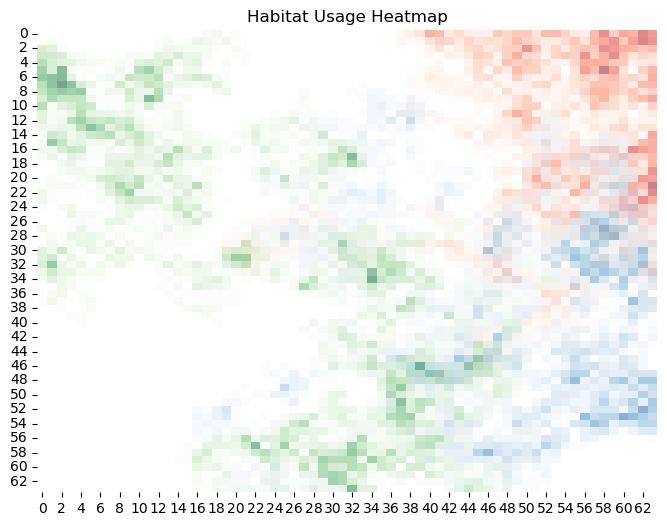

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters for the random walk
n_steps = 5000  # Number of steps in the random walk
grid_size = 64   # Size of the 2D grid

# Initialize the grid to track visit counts
grid_a = np.zeros((grid_size, grid_size))
grid_b = np.zeros((grid_size, grid_size))
grid_c = np.zeros((grid_size, grid_size))


def render_grid(src):
    # Random walk: Update the grid based on random movements
    x, y = grid_size // 2, grid_size // 2
    for _ in range(n_steps):
        # Randomly choose a direction: left, right, up, down
        dx, dy = np.random.choice([-1,0,1]), np.random.choice([-1,0,1])
        
        # Move in the chosen direction
        x = np.clip((x + dx),0,grid_size-1)  # Ensure the walk wraps around the edges
        y = np.clip((y + dy),0,grid_size-1)
    
        # Increment the visit count for the current position
        src[x, y] += 1
    return src


grid_a = render_grid(grid_a)
grid_b = render_grid(grid_b)
grid_c = render_grid(grid_c)

plt.figure(figsize=(8, 6))
sns.heatmap(grid_a, cmap="Reds", alpha=0.5, cbar=False, mask=np.where(grid_a > 0.25, 0, 1))
sns.heatmap(grid_b, cmap="Blues", alpha=0.5, cbar=False, mask=np.where(grid_b > 0.25, 0, 1))
sns.heatmap(grid_c, cmap="Greens", alpha=0.5, cbar=False, mask=np.where(grid_c > 0.25, 0, 1))
plt.title("Habitat Usage Heatmap")
plt.show()


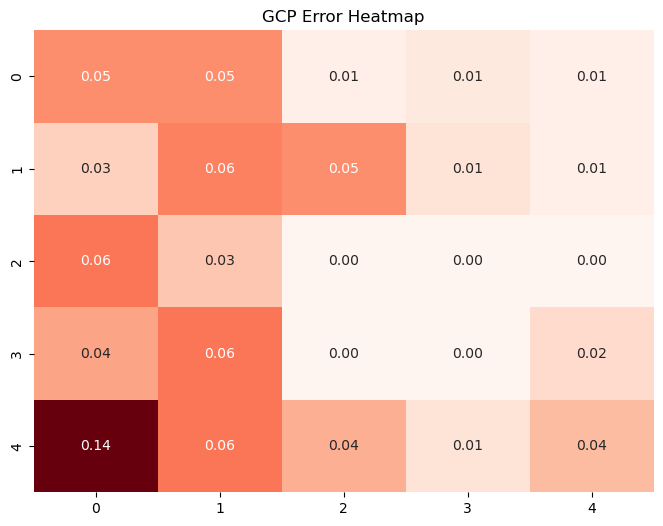

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters for the random walk
n_steps = 200  # Number of steps in the random walk
grid_size = 5   # Size of the 2D grid

# Initialize the grid to track visit counts
grid_a = np.zeros((grid_size, grid_size))


def render_grid(src):
    # Random walk: Update the grid based on random movements
    x, y = grid_size // 2, grid_size // 2
    for _ in range(n_steps):
        dx, dy = np.random.choice([-1,0,1]), np.random.choice([-1,0,1])
        x = np.clip((x + dx),0,grid_size-1)  # Ensure the walk wraps around the edges
        y = np.clip((y + dy),0,grid_size-1)
        if ((x < 1.5) or (x > grid_size - 1.5)) or ((y < 1.5) or (y > grid_size - 1.5)):
            src[x, y] += 0.005
    return src


grid_a = render_grid(grid_a)

plt.figure(figsize=(8, 6))
sns.heatmap(grid_a, cmap="Reds", alpha=1.0, cbar=False, annot=True, fmt=".2f")
plt.title("GCP Error Heatmap")
plt.show()


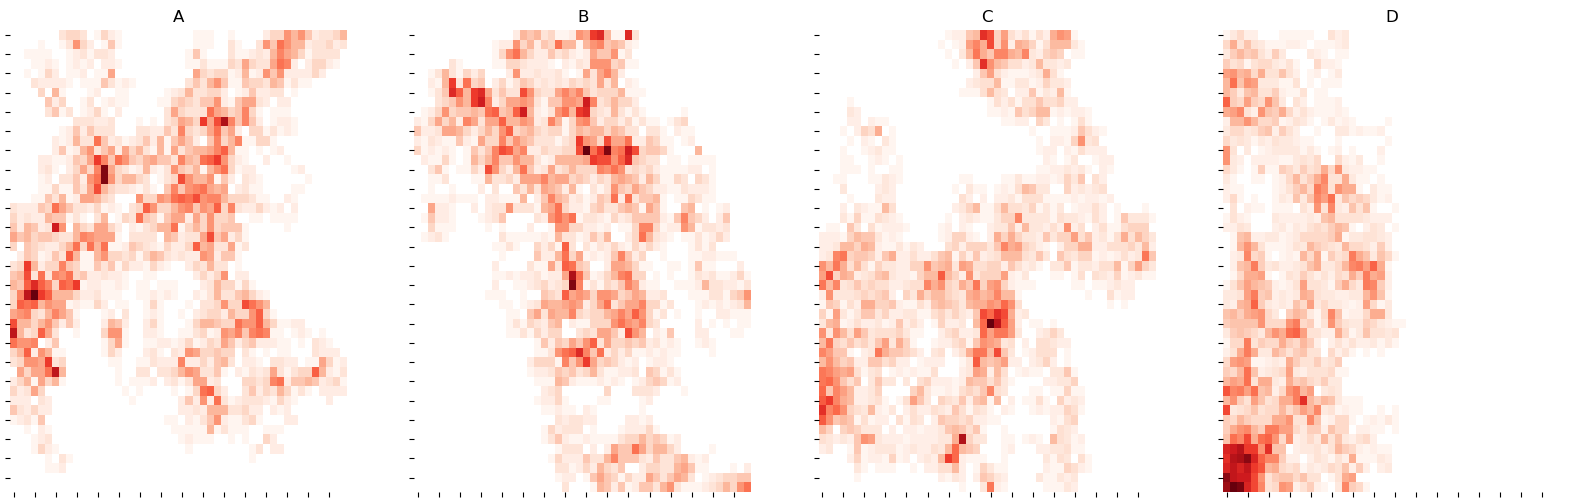

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters for the random walk
n_steps = 5000  # Number of steps in the random walk
grid_size = 48   # Size of the 2D grid

# Initialize the grid to track visit counts
grid_a = np.zeros((grid_size, grid_size))
grid_b = np.zeros((grid_size, grid_size))
grid_c = np.zeros((grid_size, grid_size))
grid_d = np.zeros((grid_size, grid_size))


def render_grid(src):
    # Random walk: Update the grid based on random movements
    x, y = grid_size // 2, grid_size // 2
    for _ in range(n_steps):
        # Randomly choose a direction: left, right, up, down
        dx, dy = np.random.choice([-1,0,1]), np.random.choice([-1,0,1])

        # Move in the chosen direction
        x = np.clip((x + dx),0,grid_size-1)  # Ensure the walk wraps around the edges
        y = np.clip((y + dy),0,grid_size-1)

        # Increment the visit count for the current position
        src[x, y] += 1
    return src


grid_a = render_grid(grid_a)
grid_b = render_grid(grid_b)
grid_c = render_grid(grid_c)
grid_d = render_grid(grid_d)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for ax, grid in zip(axes, [grid_a, grid_b, grid_c, grid_d]):
    ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])    
    sns.heatmap(grid, cmap="Reds", alpha=1.0, cbar=False, mask=np.where(grid > 0.25, 0, 1), ax=ax)
axes[0].set_title("A")
axes[1].set_title("B")
axes[2].set_title("C")
axes[3].set_title("D")
plt.show()